<a href="https://colab.research.google.com/github/doissegundos/Quebrando_Captcha_Seguranca/blob/main/predicao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Este trabalho utiliza o dataset que contém imagens de captchas de segurança com caracteres de letras e numeros.
Disponivel em: https://www.kaggle.com/fournierp/captcha-version-2-images

Acurácia do modelo: 96.73%

By: Adna

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow



### Importando as imagens salvas no google drive

In [2]:
#Para acessar as imagens do Drive
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/dataset_new' 

image_dataset_train = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'datatrain.npy'))
image_dataset_teste = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'datatest.npy'))
image_dataset_valid = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'datavalid.npy'))

label_images_train = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'labeltrain.npy'))
label_images_teste = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'labeltest.npy'))
label_images_valid = np.load(os.path.join(r'drive/My Drive/datasets/captcha', 'labelvalid.npy'))

Mounted at /content/drive


#### Processamento Digital de Imagens

A etapa de processamento digital de imagens(PDI) vai receber uma imagem de um captcha e retornar um vetor onde cada posição contem um digito recortado do captcha. Os dataset utilizado contem 5 digitos por imagem. A imagem vai sofrer trasnformações com erosão, e funções de binarização.

In [8]:
kernel =np.ones((3,2),np.uint8)
elementoEstruturante	=	cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

borderType = cv2.BORDER_CONSTANT
def pad(src): 
  top = int(0.05 * src.shape[0])  # shape[0] = rows
  bottom = top     
  left = int(0.15 * src.shape[1])  # shape[1] = cols
  right = left
  des=cv2.copyMakeBorder(src, top, bottom, left+1, right, borderType, None,255)
  return cv2.bitwise_not(des)

def pdi(imagem):
  #Normaliza a imagem de float32 para uint8
  image = cv2.normalize(imagem, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  #Converte a imagem para a escala de cinza
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Binaliza a imagem
  binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,75,10)

  #Aplica a operação de erosão sobre as imagens
  erosion =	cv2.erode(binary,	kernel,	iterations	= 1)

  #Retorna um vetor com as imagens separadas em digitos
  digito = []
  for i in range(5):
      digito.append(pad(erosion[:,(30+23*i):(30+23*(i+1))]))
  return digito

In [65]:
#Recebe os digitos recortados e tratados da imagem do captcha
imagem = np.array(pdi(image_dataset_teste[1]))
label = []
label.extend(label_images_teste[1])

y


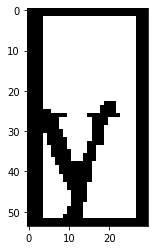

In [66]:
# Digito segmentado
plt.imshow(imagem[1], cmap='gray')
print(label[1])

#### Categorização

A etapa de categorização vai tranformar os labels das imagens para o formato onehot.

In [95]:

#retorna os labels da imagem no formato one hot
def onehot(label):
  cat = ["2","3","4","5","6","7","8","b","c","d","e","f","g","m","n","p","w","x","y"]
  label_completo = []
  for i in range(5):
    label_cat = [0]*19
    for j in range(19):
      if(label[i]!=cat[j]):
        continue
      else:
        label_cat[j] = 1
        label_completo.append(label_cat)
        break
  return label_completo

In [94]:
label_categorizado = onehot(label)
label_categorizado

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]

#### Predição

A etapa de predição vai realizar a predição de quais são os digitos das imagens. Nessa etapa é importado um modelo que já foi treinado anteriormente para realizar a predição.

In [104]:
from tensorflow.keras.models import Sequential, Model,load_model
import tensorflow as tf

In [105]:
modelo = load_model(r'drive/My Drive/datasets/captcha/modelos/CNN1.h5')

In [108]:
def predicao(imagem_completa,imagem_pdi,label):
  cat = ["2","3","4","5","6","7","8","b","c","d","e","f","g","m","n","p","w","x","y"]
  imagem_pdi = tf.expand_dims(imagem_pdi, axis=-1)
  mod = modelo.predict(imagem_pdi)
  label_categorizado = onehot(label)
  predicao, index = '',''
  for i in range(5):
    predict_index = np.argmax(mod[i])
    true_index = np.argmax(label_categorizado[i])

    #fazendo a predição
    predicao = predicao + cat[predict_index]
    index = index + cat[true_index]

  plt.imshow(imagem_completa, cmap='gray')
  print("Predição: " + predicao)
  print("Label correto: " + index)



Predição: gm2c2
Label correto: gm2c2


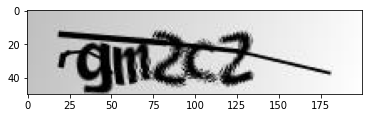

In [115]:
#Seleciona uma imagem do dataset para realizar o teste. Só pode ser selecionadas imagens do dataset de teste, pois as imagens de treinamento e validação ja foram utilizadas para treinar o modelo
imagem_completa = image_dataset_teste[5]
label_completo = label_images_teste[5]

#Recebe os digitos recortados e tratados da imagem do captcha
imagem_pdi = np.array(pdi(imagem_completa))
label = []
label.extend(label_completo)
#Faz a predição
predicao(imagem_completa,imagem_pdi,label)